CNN 모델의 중간 convolution 층의 웨이트와 출력을 봅시다. 먼저 저장된 모델을 읽어오고 구조를 확인합니다.

In [1]:
from tensorflow.keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

model = models.load_model('mnist_model_channels_last.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928

데이터셋을 읽어옵니다.

train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8
train_labels <class 'numpy.ndarray'> (60000,) uint8
test_images <class 'numpy.ndarray'> (10000, 28, 28) uint8
test_labels <class 'numpy.ndarray'> (10000,) uint8


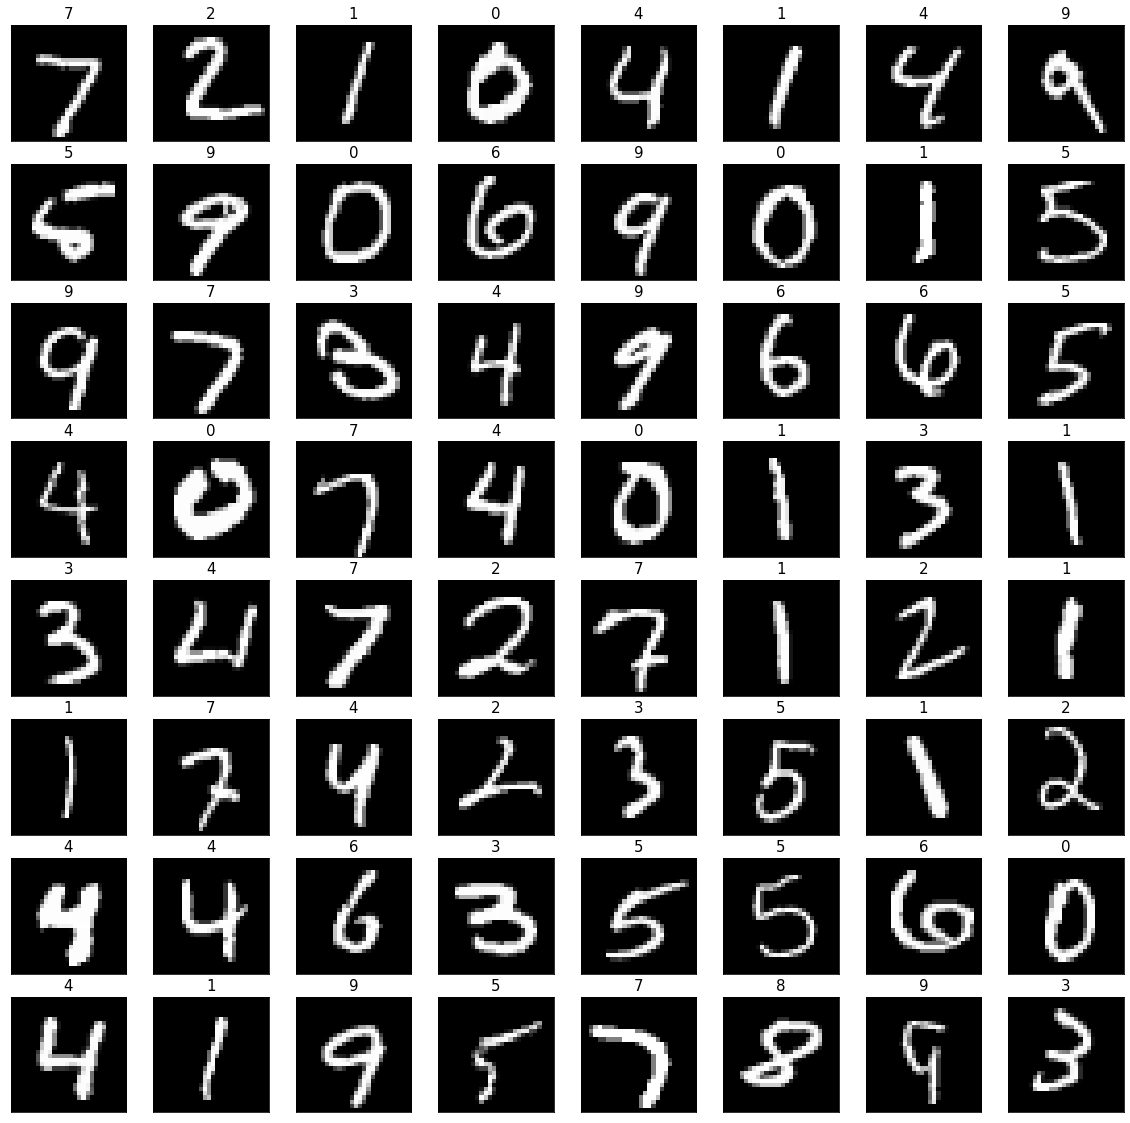

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'train_labels', type(train_labels), train_labels.shape, train_labels.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )
print( 'test_labels', type(test_labels), test_labels.shape, test_labels.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( test_labels[i], {'fontsize':15} )
    plt.imshow( test_images[i], cmap="gray" )

channels_last 모델을 읽어왔기 때문에 입력 이미지의 모양을 channels_last 에 맞추고 정규화를 해 줍니다.

In [3]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
test_x = ( test_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 28, 28, 1) float32


레이블을 열개의 카테고리를 가진 데이터로 바꾸어 줍니다.

In [4]:
num_classes = 10

print( 'test_labels', test_labels.shape, test_labels.dtype )
print( 'test_labels[0] =', test_labels[0] )

train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes)

print( 'test_y', test_y.shape, test_y.dtype )
print( 'test_y[0] =', test_y[0] )

test_labels (10000,) uint8
test_labels[0] = 7
test_y (10000, 10) float32
test_y[0] = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


테스트 데이터로 검증합니다.

In [5]:
evaluation = model.evaluate( test_x, test_y, batch_size=128)
print( '[loss, accuracy] =', evaluation )

10000/10000 [==============================] - 2s 155us/sample - loss: 0.0260 - accuracy: 0.9918
[loss, accuracy] = [0.025971521640966604, 0.9918]


다음과 같이 두 번째 convolution 층의 웨이트의 shape 을 보면 image_data_format 이 channels_first 이던 channels_last 이던 (height, width, depth, filters) 인것을 알 수 있습니다. 다음은 각각 필터의 depth 0 를 시각화 한 것입니다.

weights[0].shape = (3, 3, 32, 64)
weights[1].shape = (64,)


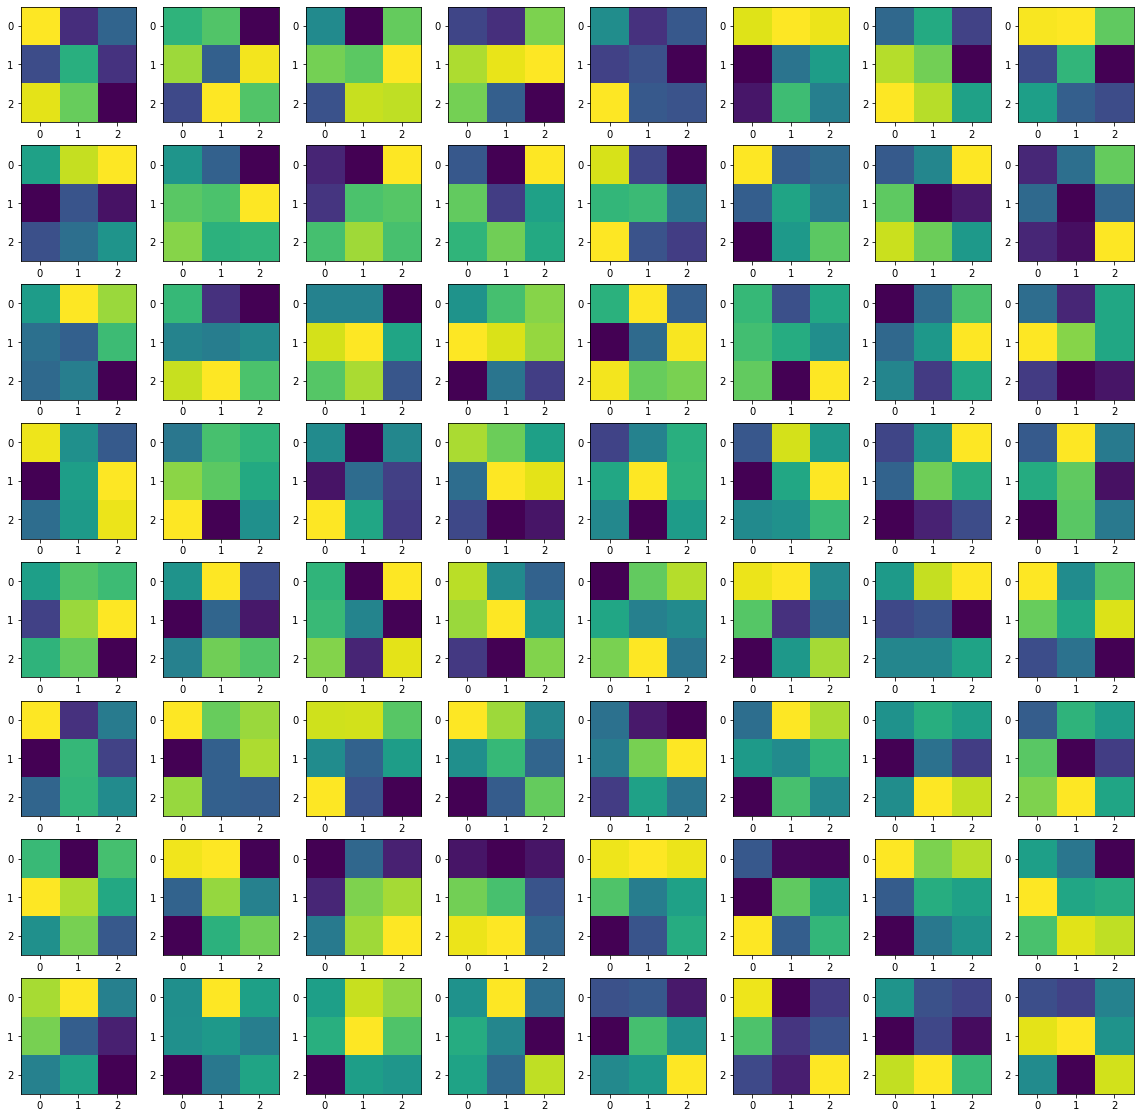

In [6]:
weights = model.get_layer(index=3).get_weights()
print( 'weights[0].shape =', weights[0].shape )
print( 'weights[1].shape =', weights[1].shape )
plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow( weights[0][:,:,0,i] )

첫 번째 convolution 층의 출력을 받는 모델을 만들고 입력을 넣어주고 결과를 받습니다. 출력의 모양은 channels_last 이기 때문에 (batch, height, width, depth) 인것을 알 수 있습니다. 특정 입력 이미지에대한 출력의 모든 depth 의 feature map 을 시각화해 봅니다.

conv_output.shape = (None, 26, 26, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
conv_pred.shape = (10000, 26, 26, 32)


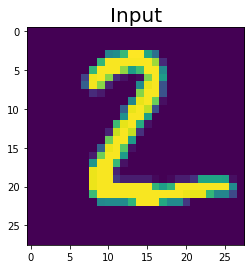

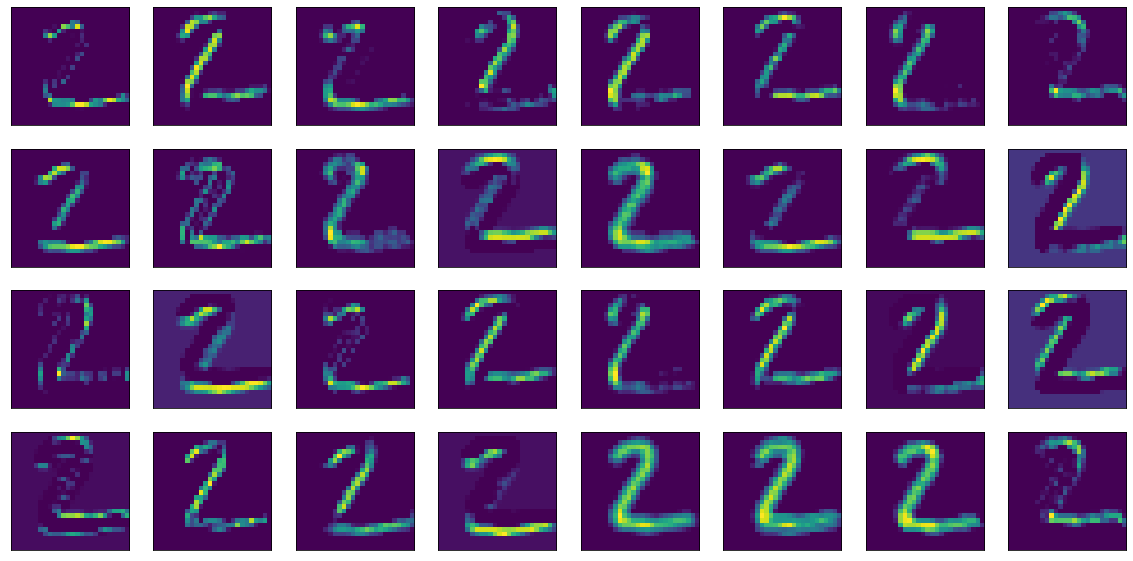

In [7]:
conv_output = model.get_layer(index=1).output
print( 'conv_output.shape =', conv_output.shape )
conv_model = models.Model( model.input, conv_output )
conv_model.summary()

conv_pred = conv_model.predict( test_x )
print( 'conv_pred.shape =', conv_pred.shape )

sample_index = 1
plt.title( "Input", {'fontsize':20} )
plt.imshow( test_x[sample_index,:,:,0] )

plt.figure(figsize=(20,10))
for i in range(0,32):
    plt.subplot(4,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( conv_pred[sample_index,:,:,i] )